<a href="https://colab.research.google.com/github/odus05/Image_Retrieval/blob/master/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import keras
from keras.layers import Conv2D, Flatten, Dense, Lambda, Reshape, Conv2DTranspose 
from keras import backend as K
from keras.models import Model, Input
from keras.optimizers import adam

In [0]:
# 1. 입력 이미지를 잠재 공간의 두 파라미터 z_mean과 z_log_var로 변환합니다!
# 2. 입력 이미지가 생성되었다고 가정한 잠재 공간의 정규분포에서 포인트 z를 z = z_mean + exp(0.5 * z_log_variance) * epsilon와 같이 무작위로 샘플링합니다.
# 3. 디코더 모듈은 잠재 공간의 이 포인트를 원본 입력 이미지로 매핑하여 복원합니다.
# 4. epsilon이 무작위로 만들어지기 때문에 input_img를 인코딩한 잠재 공간의 위치(z_mean)에 가까운 포인트는 input_img와 비슷한 이미지로 디코딩될 것입니다. 
# 5. VAE의 파라미터는 두 개의 손실 함수로 훈련합니다. 디코딩된 샘플이 원본 입력과 동일하도록 만드는 재구성 손실과 잠재 공간을 잘 형성하고 훈련 데이터에 과대적합을 줄이는 규제 손실입니다.

In [0]:
#### 입력 이미지를 평균과 분산 파라미터로 인코딩합니다
# 이미지를 잠재 공간 상의 확률 분포 파라미터로 매핑하는 인코더 네트워크입니다. 
# 입력 이미지 x를 두 벡터 z_mean과 z_log_var로 매핑하는 간단한 컨브넷입니다.

img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2 # 잠재 공간의 2차원 평면

input_img = Input(shape=img_shape)
x = Conv2D(32, 3,
           padding='same', activation='relu')(input_img)
x = Conv2D(64,3,
           padding='same', activation='relu', strides=(2,2))(x)
x = Conv2D(64,3,
           padding='same', activation='relu')(x)
x = Conv2D(64,3,
           padding='same', activation='relu')(x)     

shape_before_flattening = K.int_shape(x)

x = Flatten()(x)
x = Dense(32, activation='relu')(x)

z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

In [9]:
### 무작위로 선택한 작은 epsilon 값을 사용해 잠재 공간의 포인트를 뽑습니다
# 이 두 파라미터가 input_img를 생성한 통계 분포의 파라미터라고 가정하고 잠재 공간 포인트 z를 생성합니다. 
# 여기에서 (케라스의 백엔드 기능으로 만든) 일련의 코드를 Lambda 층으로 감쌉니다. 
# 케라스에서는 모든 것이 층이므로 기본 층을 사용하지 않은 코드는 Lambda로 (또는 직접 만든 층으로) 감싸야 합니다.
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

In [0]:
### z를 이미지로 디코딩합니다
# 벡터 z를 이전 특성 맵 차원으로 크기를 바꾸고 몇 개의 합성곱 층을 사용해 최종 출력 이미지를 만듭니다.
# 최종 이미지는 원본 input_img와 차원이 같습니다.

# Input에 z를 주입합니다
decoder_input = Input(K.int_shape(z)[1:])

# 입력을 업샘플링합니다
x = Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# 인코더 모델의 마지막 Flatten 층 직전의 특성 맵과 같은 크기를 가진 특성 맵으로 z의 크기를 바꿉니다
x = Reshape(shape_before_flattening[1:])(x)

# Conv2DTranspose 층과 Conv2D 층을 사용해 z를 원본 입력 이미지와 같은 크기의 특성 맵으로 디코딩합니다
x = Conv2DTranspose(32, 3,
                    padding='same', activation='relu',
                    strides=(2, 2))(x)
x = Conv2D(1, 3,
          padding='same', activation='sigmoid')(x)
# 특성 맵의 크기가 원본 입력과 같아집니다

# 디코더 모델 객체를 만듭니다
decoder = Model(decoder_input, x)

# 모델에 z를 주입하면 디코딩된 z를 출력합니다
z_decoded = decoder(z)

In [13]:
# 일반적인 샘플 기준의 함수인 loss(y_true, y_pred) 형태는 VAE의 이중 손실에 맞지 않습니다.
# add_loss 내장 메서드를 사용하는 층을 직접 만들어 임의의 손실을 정의하겠습니다.

class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # 출력 값을 사용하지 않습니다
        return x

# 입력과 디코딩된 출력으로 이 층을 호출하여 모델의 최종 출력을 얻습니다
y = CustomVariationalLayer()([input_img, z_decoded])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:
# 이제 모델 객체를 만들고 훈련할 준비가 되었습니다. 
# 층에서 손실을 직접 다루기 때문에 compile 메서드에서 손실을 지정하지 않습니다(loss=None).
# 그 결과 훈련하는 동안 타깃 데이터를 전달하지 않아도 됩니다(다음 코드처럼 모델의 fit 메서드에 x_train만 전달합니다).

vae = Model(input_img, y)
vae.compile(optimizer='adam', loss=None)
vae.summary()

# MNIST 숫자 이미지에서 VAE를 훈련합니다
from keras.datasets import mnist
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))


vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 28, 28, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 14, 14, 64)   18496       conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 14, 14, 64)   36928       conv2d_10[0][0]                  
____________________________________________________________________________________________

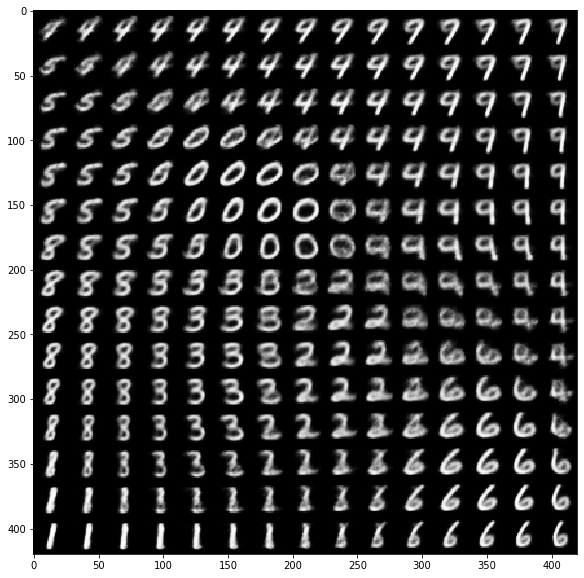

In [18]:
# MNIST 데이터셋으로 모델의 훈련을 마치면 디코더 네트워크를 사용하여 잠재 공간의 임의의 벡터를 이미지로 변환할 수 있습니다:
# 샘플링된 숫자의 그리드는 다른 숫자 클래스 사이에서 완벽하게 연속된 분포를 보여줍니다. 
# 잠재 공간의 한 경로를 따라서 한 숫자가 다른 숫자로 자연스럽게 바뀝니다.
# 이 공간의 특정 방향은 어떤 의미를 가집니다. 예를 들어 '6으로 가는 방향', '9로 가는 방향' 등입니다.

import matplotlib.pyplot as plt
from scipy.stats import norm

# Display a 2D manifold of the digits
n = 15  # 15 × 15 숫자의 그리드를 출력합니다
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# 싸이파이 ppf 함수를 사용하여 일정하게 떨어진 간격마다 잠재 변수 z의 값을 만듭니다
# 잠재 공간의 사전 확률은 가우시안입니다
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()